### Centerline extraction demo using geodesic distance transform 
#### Reference.
Teng, Pang-yu, Ahmet Murat Bagci, and Noam Alperin. "Automated prescription of an optimal imaging plane for measurement of cerebral blood flow by phase contrast magnetic resonance imaging." IEEE Transactions on Biomedical Engineering 58.9 (2011): 2566-2573.
https://www.ncbi.nlm.nih.gov/pubmed/21672671

In [1]:
import numpy as np
from scipy.ndimage.morphology import binary_dilation
import SimpleITK as sitk
from scipy import interpolate
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_2553/3746355266.py:2: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


In [2]:
from scipy.ndimage import distance_transform_edt
from extract_centerline import extract_centerline, smooth_3d_array
from extract_slice import extract_slice

In [46]:
num = 10000
def mock_image():
    mpl.rcParams['legend.fontsize'] = 10    
    const = 100
    theta = np.linspace(-4 * np.pi, 4 * np.pi, num)
    z = np.linspace(0, 10, num)
    r = z**2 + 3
    x = r * np.sin(theta) + const
    y = r * np.cos(theta) + const
    z = z*4
    img = np.zeros([256,256,50])
    for i,j,k in zip(x,y,z):
        img[int(i),int(j),int(k)]=1
    img=binary_dilation(img,iterations=5)
    return img,x,y,z


In [47]:
img,x,y,z = mock_image()
print(img.shape)
start_point = np.array([x[0],y[0],z[0]]).astype(int)
end_point = np.array([x[-1],y[-1],z[-1]]).astype(int)
search_radius=(1,1,1)
centerline_list = extract_centerline(img,start_point,end_point,search_radius=search_radius)
c_x,c_y,c_z = centerline_list

(256, 256, 50)


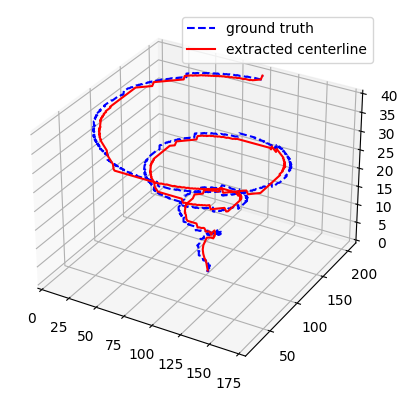

In [48]:
x_int = x.astype(int)
y_int = y.astype(int)
z_int = z.astype(int)

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(x_int, y_int, z_int, label='ground truth',linestyle='--',color='blue')
ax.plot(c_x,c_y,c_z, label='extracted centerline',color='red')
ax.legend()

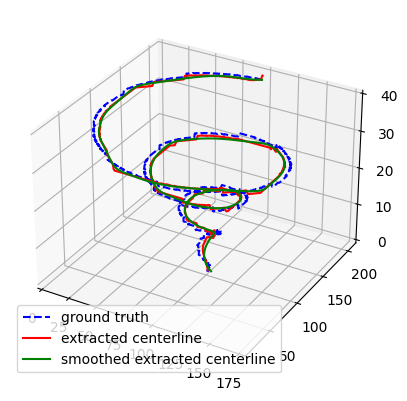

In [49]:
smothing_factor = 100
# original paper used cubic smoothing spline, not the below.
s_x,s_y,s_z = smooth_3d_array(c_x,c_y,c_z,s=smothing_factor)
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(x_int, y_int, z_int, label='ground truth',linestyle='--',color='blue')
ax.plot(c_x,c_y,c_z, label='extracted centerline',color='red')
ax.plot(s_x,s_y,s_z, label='smoothed extracted centerline',color='green')
ax.legend()
plt.show()

In [81]:
print(np.min(img),np.max(img),img.shape)

bsfield = distance_transform_edt(img)
img_obj = sitk.GetImageFromArray(np.moveaxis(img,-1,0).astype(float))
img_obj.SetOrigin((0,0,0))
img_obj.SetDirection((1,0,0,0,1,0,0,0,1))
img_obj.SetSpacing((1,1,1))
gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
gaussian.SetSigma(2)
img_obj = gaussian.Execute(img_obj)
tmp = sitk.GetArrayFromImage(img_obj)

print(np.min(tmp),np.max(tmp),img_obj.GetSize())

False True (256, 256, 50)
-0.0018941705 0.96708024 (256, 256, 50)


In [82]:
sitk.WriteImage(img_obj,'img.nii.gz')

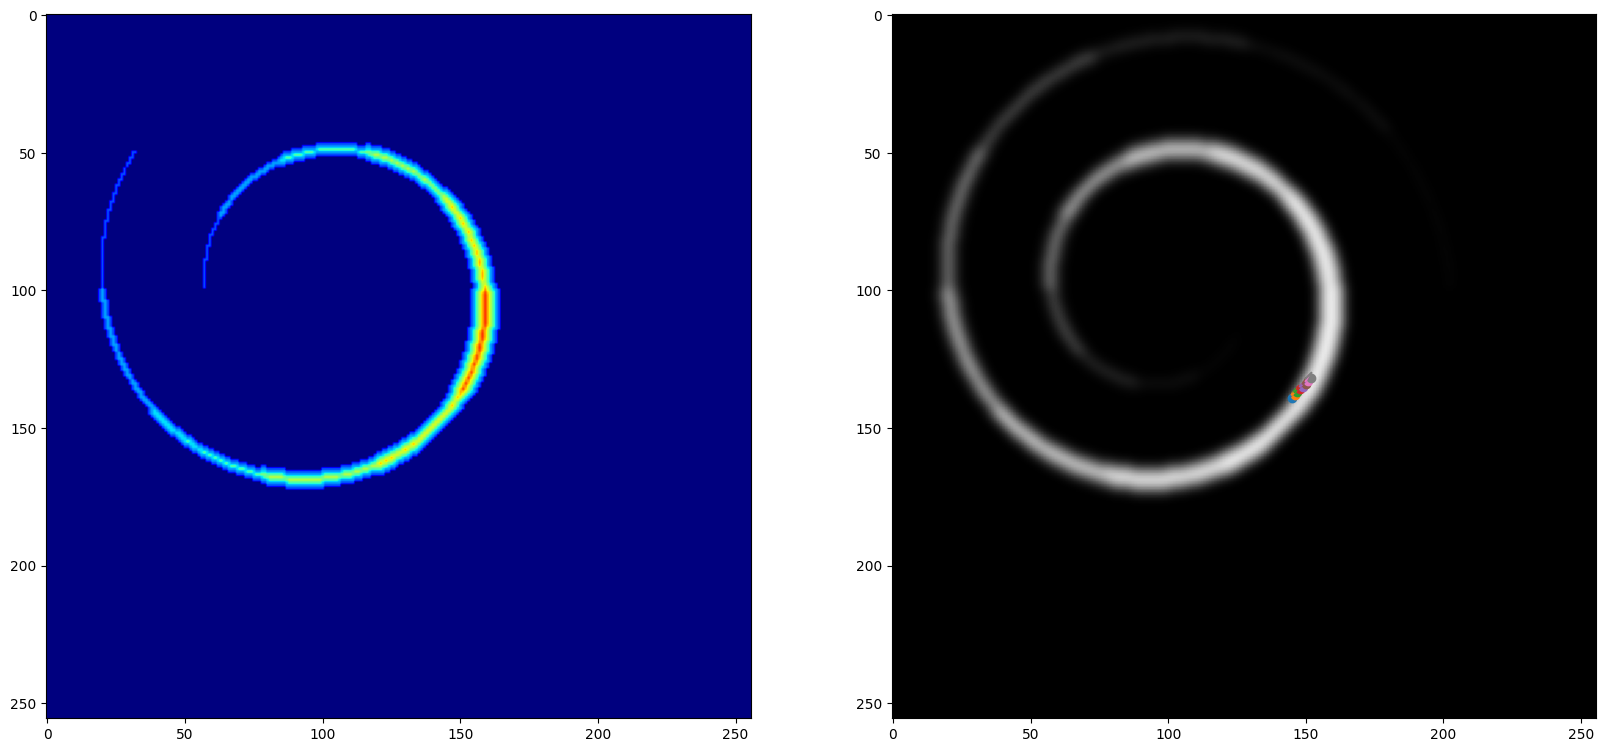

In [90]:
offset = 1
myz = 30
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(bsfield[:,:,myz].squeeze(),cmap='jet',vmin=0,vmax=5)
plt.subplot(122)
plt.imshow(tmp[myz,:,:].squeeze(),cmap='gray',vmin=0,vmax=1)
for n,idx in enumerate(range(len(s_z))):
    slice_center = int(c_x[idx  ]),int(c_y[idx  ]),int(c_z[idx  ])
    if slice_center[2] != myz:
        continue
    before_point = int(s_x[idx-offset]),int(s_y[idx-offset]),int(s_z[idx-offset])
    after_point  = int(s_x[idx+offset]),int(s_y[idx+offset]),int(s_z[idx+offset])
    plt.scatter(slice_center[1],slice_center[0])
    plt.plot([before_point[1],after_point[1]],[before_point[0],after_point[0]],linestyle='-')

392,(139.0, 145.0, 30.0),[-2.  2.  0.],(20, 20, 1),1.0
393,(138.0, 146.0, 30.0),[-2.  2.  0.],(20, 20, 1),1.4142135623730951
394,(137.0, 147.0, 30.0),[-2.  2.  0.],(20, 20, 1),1.4142135623730951
395,(136.0, 148.0, 30.0),[-2.  2.  0.],(20, 20, 1),2.23606797749979
396,(135.0, 149.0, 30.0),[-2.  2.  0.],(20, 20, 1),2.449489742783178
397,(134.0, 150.0, 30.0),[-2.  1.  0.],(20, 20, 1),2.8284271247461903
398,(133.0, 151.0, 30.0),[-2.  1.  0.],(20, 20, 1),3.0
399,(132.0, 152.0, 30.0),[-2.  2. -1.],(20, 20, 1),3.4641016151377544


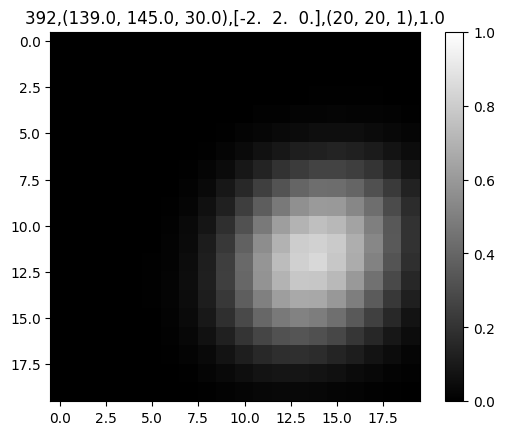

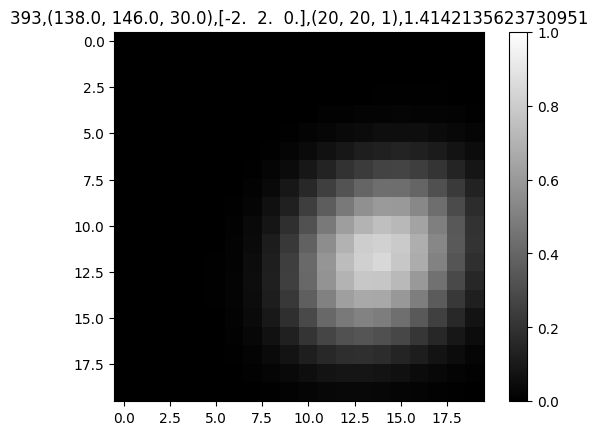

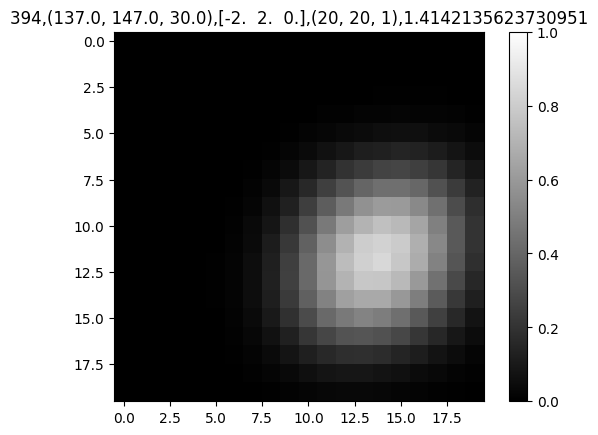

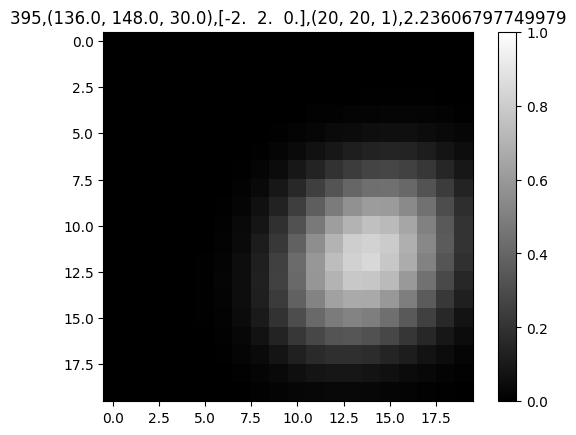

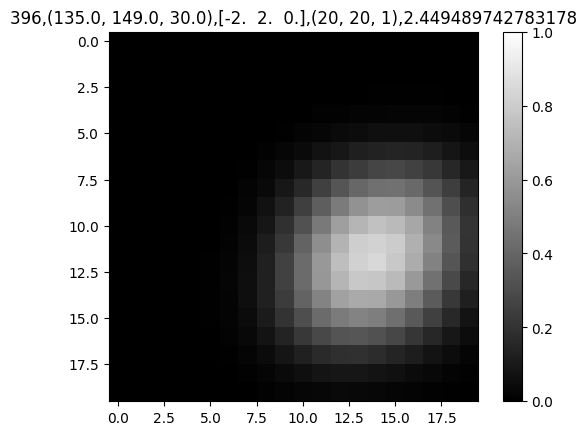

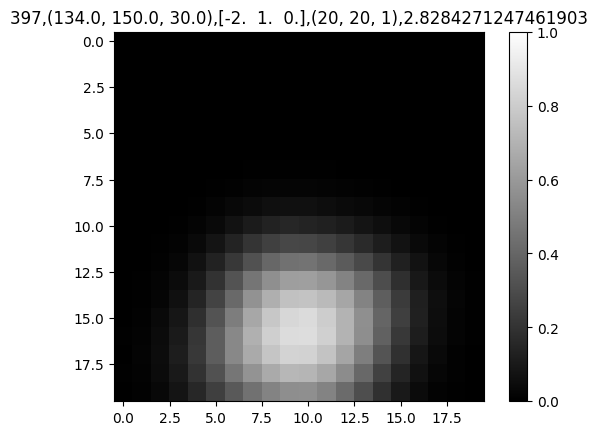

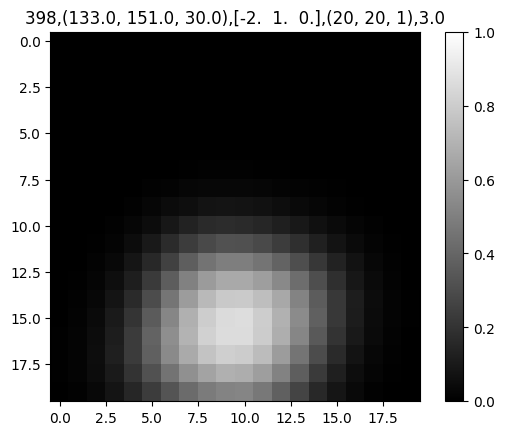

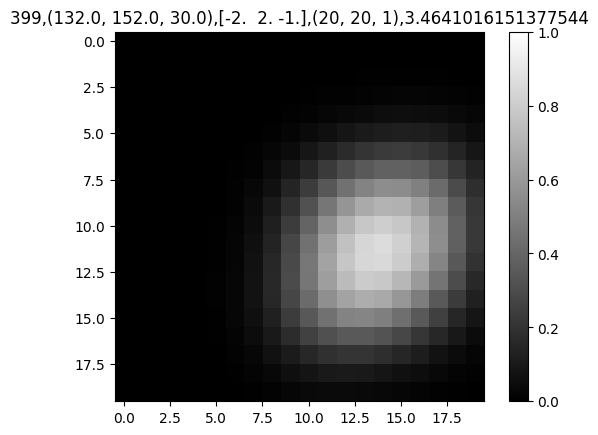

In [92]:

for n,idx in enumerate(range(len(s_z))):

    slice_center = int(c_x[idx  ]),int(c_y[idx  ]),int(c_z[idx  ])
    if slice_center[2] != myz:
        continue
    before_point = int(s_x[idx-offset]),int(s_y[idx-offset]),int(s_z[idx-offset])
    after_point  = int(s_x[idx+offset]),int(s_y[idx+offset]),int(s_z[idx+offset])

    appx_radius = bsfield[slice_center[0],slice_center[1],slice_center[2]]
    
    slice_center = img_obj.TransformContinuousIndexToPhysicalPoint(slice_center)
    before_point = img_obj.TransformContinuousIndexToPhysicalPoint(before_point)
    after_point = img_obj.TransformContinuousIndexToPhysicalPoint(after_point)
    slice_normal = np.array(after_point)-np.array(before_point)
    slice_spacing = (1,1,1) # mm
    slice_size= (int(appx_radius)*10,int(appx_radius)*10,1) # voxel
    slice_size = (20,20,1)#
    is_label = False
    
    slice_obj = extract_slice(img_obj,slice_center,slice_normal,slice_spacing,slice_size,is_label)    
    slice_arr = sitk.GetArrayFromImage(slice_obj)
    title = f"{idx},{slice_center},{slice_normal},{slice_size},{appx_radius}"
    print(title)

    sitk.WriteImage(slice_obj,f'slice{idx:03d}.nii.gz')
    plt.figure(idx)
    plt.title(title)
    plt.imshow(slice_arr.squeeze(),cmap='gray',vmin=0,vmax=1)
    plt.colorbar()